# Nessie tutorial:

In this tutorial we will be building a quick group catalog from the Sloan digital sky survey (SDSS).



## Download the SDSS data

To do this we will use astroquery and download the galaxies that were used in Tempel+2017 as well as the groups they found them in. This could take a minute or two but feel free to save the file to disk for later use.


In [ ]:
from astroquery.vizier import Vizier

columns = ["GroupID", "Ngal", "zobs", "RAJ2000", "DEJ2000", "zmag"]
vizier = Vizier(columns = columns, row_limit = -1)
sdss_galaxies = vizier.get_catalogs("J/A+A/602/A100/table1")


In [ ]:
import numpy as np
catalog = sdss_galaxies[0]
ra  = np.array(catalog['RAJ2000'])
dec = np.array(catalog['DEJ2000'])
mult = np.array(catalog['Ngal'])
redshift = np.array(catalog['zobs'])
mag = np.array(catalog['zmag'])
tempel_group_id = np.array(catalog['GroupID'])

cut = np.where(mag < 18)[0]



SyntaxError: invalid syntax (4271424975.py, line 9)

# Building the running density from n(z)

The running density might look confusing but `Nessie` will handle building it if you can get a decent approximation of the n(z). This method is a little verbose at the momemnt but future editions of `Nessie` will calculate this automatically from the data itself. In the meantime we have to do a little pre-processing. 

## First order approximation

The very easiest method of approximating the n(z) is to just get it directly from the data itself

Text(0, 0.5, 'Counts')

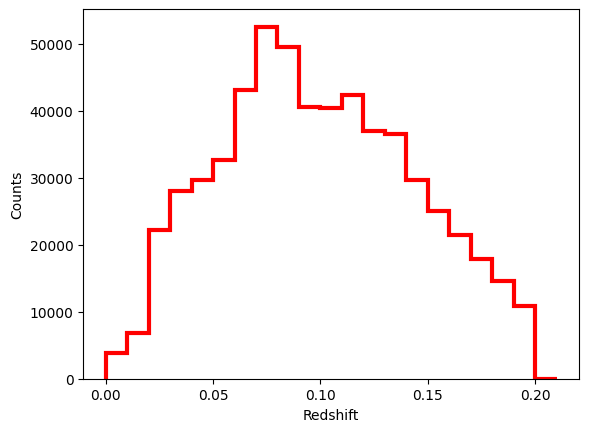

In [15]:
from pylab import plt
import numpy as np

plt.hist(catalog['zobs'], bins = np.arange(0, 0.22, 0.01), histtype='step', lw=3, color='r')
plt.xlabel("Redshift")
plt.ylabel("Counts")


We can pass this data to `Nessie` to build the density function that we need for group findig


In [20]:
from nessie.helper_funcs import create_density_function
from nessie import FlatCosmology
SDSS_FRACTIONAL_AREA = 0.2126803
cosmo = FlatCosmology(0.7, 0.3) # Notice this is NOT an astropy object.
rho_basic = create_density_function(catalog['zobs'], len(catalog['zobs']), SDSS_FRACTIONAL_AREA, cosmo)

This is easy but for real scientific work you'd want to do a better job of getting the n(z) correct although even this basic first start is useful. One could also run a box car over the distribution.

 Slightly more appropriate (but still incomplete) would be to fit a skewed normal to the data and build a distribution from that that we can pass as the n(z). 

Text(0, 0.5, 'normalzied counts')

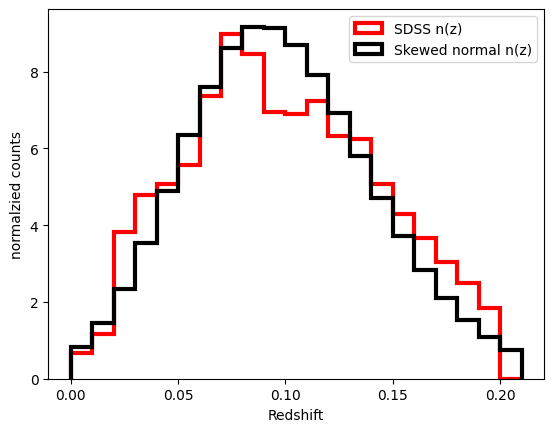

In [38]:
from scipy.stats import skewnorm
a_fit, loc_fit, scale_fit = skewnorm.fit(catalog['zobs'])
MULTIPLE_FACTOR = 10
n_randoms = len(catalog['zobs']) * MULTIPLE_FACTOR# Make the randoms catalogue 10x the redshift array.
z_randoms = skewnorm.rvs(a=a_fit, loc = loc_fit, scale = scale_fit, size=n_randoms)

plt.hist(catalog['zobs'], bins = np.arange(0, 0.22, 0.01), histtype='step', lw=3, color='r', density=True, label = 'SDSS n(z)')
plt.hist(z_randoms,  bins = np.arange(0, 0.22, 0.01), histtype='step', lw=3, color='k', density=True, label="Skewed normal n(z)")
plt.legend()
plt.xlabel('Redshift')
plt.ylabel("normalzied counts")


From the plot we can see that the skewed normal has roughly the same shape but doesn't have the same underlying effects from large-scale structure.

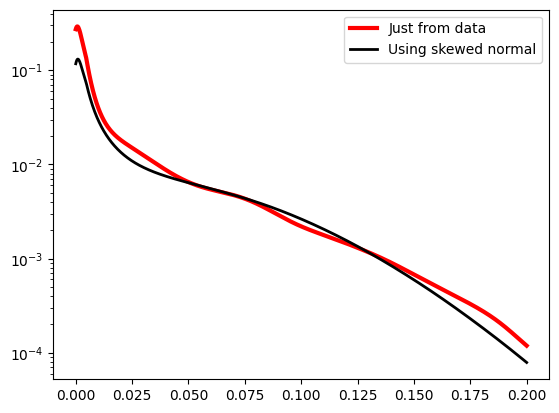

In [39]:
rho_skewed = create_density_function(z_randoms, len(z_randoms)/MULTIPLE_FACTOR, SDSS_FRACTIONAL_AREA, cosmo)

redshifts = np.linspace(0, 0.2, 1000)

plt.plot(redshifts, rho_basic(redshifts), lw=3, color='r', label='Just from data')
plt.plot(redshifts, rho_skewed(redshifts), lw=2, color='k', label='Using skewed normal')
plt.yscale('log')
plt.legend()



As can be seen from the plot, they are quite similiar but will have an effect on the final catalogue so it is worth getting this as good as you can when you actually run the group finder seriously. We recommend implementing a randoms catalogue like described in Cole+2011 and Farrow+2015
https://arxiv.org/abs/1104.0009

https://ui.adsabs.harvard.edu/abs/2015MNRAS.454.2120F/abstract

in the future these algorithms will be included in Nessie to automatically build the most accurate running density possible automatically. 


# Running the group finder

Once the density function has been built actually running the group finder on the data becomes a relatively trivial process. If you already know what your linking length constants, b0, and r0 should be.

In [43]:
from nessie import RedshiftCatalog

# build the RedshiftCatalog object.
ra = np.array(catalog['RAJ2000'])
dec = np.array(catalog['DEJ2000'])
redshift = np.array(catalog['zobs'])

red_cat = RedshiftCatalog(ra, dec, redshift, rho_basic, cosmo)

red_cat.run_fof(b0=0.05, r0=18)



The python version of `nessie` doesn't yet have tuning capabilities built (to find the optimum set of parameters). But you can calulcut the Figure of Merit score which can be used as a log-likely hood to optimize. Or just map out the full parameter space if you have the time. This would usually be done with a simulation or mock catalog. 

In this example we use the score to calculate how well the overlap between the published group catalog (GroupID column) and our restults given the choice of parameters. This highlights how flexible `nessie` is but also how one could improve on the choice of linking lengths. 

In [47]:
# first set the mock group ids (The "true" IDs)

mock_ids = np.array(catalog['GroupID'])
mock_ids[mock_ids == 0] = -1 # -1 has to be used as the id of galaxies not found in a group.

red_cat.mock_group_ids = mock_ids
s_total = red_cat.compare_to_mock()
average_overlap = s_total**(1/4)
print("Average overlap with SDSS:", average_overlap)


Average overlap with SDSS: 0.8247057683775538


The s_total score scales in such a way that the average contribution to all four terms is s_total^(1/4) so to get the average overlap one needs to scale appropriately like the above example. 

Naturally, the group finder can be run with multiple different values for b0 and r0 in order to find the maximim value of s_total over some parameter space. And the user can do this in any appropriate manner.

# Getting group properties


In order to get the full group catalog including all the properties, we need to pass the absolute magnitudes of the survey as well as the velocity errors of the redshifts.

There are many ways to calculate the absolute magnitudes which incldue taking into account various different correction K-correction, K+E correction, SED fitting etc. The user is free to determine the best absolute magnitudes possible. 

The simpliest method is just to use the redshifts and the distance modulus which is available in the FlatCosmology object

In [53]:
absolute_mags = np.array(catalog['zmag'] - cosmo.dist_mod(catalog['zobs']))
vel_errs = np.ones(50) * len(catalog['zobs']) # just assuming +- 50km/s on the velocity errors.

print(min(catalog['zmag']), max(catalog['zmag']))

8.758888 37.464824


(array([3.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 3.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 3.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 3.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 2.000e+00, 2.000e+00, 3.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 2.000e+00, 3.000e+00, 4.000e+00, 3.000e+00,
        2.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 3.000e+00,
        3.000e+00, 1.000e+00, 2.000e+0

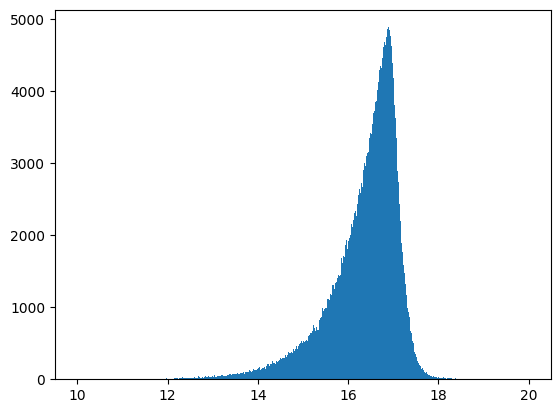

In [55]:
plt.hist(catalog['zmag'], bins=np.arange(10, 20, 0.01))